# Extensin % spliced

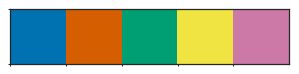

In [15]:
import sys
import os
from glob import glob
import re
from collections import Counter

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import pysam

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [4]:
ext_table = pd.read_csv('../extensin_showalter_table/ext_table.csv')
ext_table.head()

,AGI Identifier,gene_symbol,class,expression_tissue,sp3_motif,sp4_motif,sp5_motif,yxy_motif,chrom,start,end,strand,gene_length,overlapping_pg4,filtered_pg4,merged_pg4,logFC,logCPM,FDR
0,AT1G26240,EXT20,SP5,Roots,2,1,40,44,1,9077873,9079646,-,1773,440,102,44,3.721471,6.802750,1.096868e-168
1,AT1G26250,EXT21,SP5,Roots,7,0,28,40,1,9083837,9085464,+,1627,480,92,38,-3.403088,5.565503,5.061161e-10
2,AT4G08370,EXT22,SP5,NaN,3,1,13,18,4,5301961,5303314,-,1353,441,70,25,NaN,NaN,NaN
3,AT4G13390,EXT18,SP5/SP4,Roots,0,14,8,13,4,7783790,7785366,+,1576,634,68,31,-2.627889,5.474627,8.447693e-28
4,AT5G19810,EXT19,SP5/SP4,Roots,0,4,13,1,5,6692908,6694058,+,1150,466,70,21,NaN,NaN,NaN


In [62]:

BED_CONVERTERS = {
    'chrom': str,
    'start': int,
    'end': int,
    'gene_id': str,
    'is_reverse': lambda x: x == '-',
}


def load_bed(bed_fn):
    return pd.read_table(
        bed_fn,
        sep='\t',
        names=['chrom', 'start', 'end', 'gene_id', '_', 'is_reverse'],
        converters=BED_CONVERTERS,
        usecols=[0, 1, 2, 3, 5],
        index_col='gene_id'
    )


def check_orientation(aln, gene_reverse):
    # correct for reversely stranded libraries
    if gene_reverse ^ bool(aln.is_reverse):
        return bool(aln.is_read1)
    else:
        return bool(aln.is_read2)


def count_splice_juncs(bam, chrom, start, end, gene_reverse):
    aligned_reads = bam.fetch(chrom, start, end)
    spliced_count = Counter()
    for aln in aligned_reads:
        if check_orientation(aln, gene_reverse):
            spliced_count['N' in aln.cigarstring] += 1
    return (spliced_count[True] / sum(spliced_count.values()), 
            sum(spliced_count.values()))

In [33]:
fn = glob('/home/matthew/sharc_fastdata/tair10_nmm_splicing/star_splice_junct/*.sorted.bam')
fn.sort()

bams = [pysam.AlignmentFile(b) for b in fn]

perc = {}
for gene_id, sc, sp, tot in count_percent_spliced(bams,
                                                  load_bed('./araport11_genes.bed'),
                                                  ext_table['AGI Identifier'].tolist()):
    if (np.array(tot) > 100).all():
        perc[gene_id] = sp

In [48]:
percentage_spliced = pd.DataFrame.from_dict(perc, orient='index')
percentage_spliced.columns = [
    'Negative_1', 'NMM_1', 'Negative_2', 'NMM_2', 'Negative_3', 'NMM_3'
]
percentage_spliced_long = percentage_spliced.stack().reset_index()
percentage_spliced_long.columns = ['gene_id', 'sample', 'percent_spliced']
percentage_spliced_long[['cond', 'sample']] = percentage_spliced_long['sample'].str.split('_', expand=True)
percentage_spliced_long.head()

,gene_id,sample,percent_spliced,cond
0,AT1G26250,1,12.971740,Negative
1,AT1G26250,1,15.611814,NMM
2,AT1G26250,2,14.240971,Negative
3,AT1G26250,2,12.482853,NMM
4,AT1G26250,3,14.723468,Negative


In [51]:
%%bash
source activate cgat_python2
cgat gtf2gtf --method=merge-exons --filter=proteincoding \
  -I /home/matthew/Documents/genomes/tair10/gff/Araport11_GFF3_genes_transposons.201606.gtf \
  -L /dev/null | 
awk -v OFS='\t' '$3 == "exon" {print $10}' | 
sed -e 's/[";]//g' | uniq -c | 
awk -v OFS='\t' '{print $2, $1}' > araport_n_exons.tsv

In [52]:
exons = pd.read_table('./araport_n_exons.tsv',
                      sep='\t', names=['gene_id', 'n_exons'])
intronless_ext = extensins[extensins.gene_id.isin(exons[exons.n_exons == 1].gene_id)]
exons.head()

,gene_id,n_exons
0,AT1G01010,6
1,AT1G01020,7
2,AT1G03987,1
3,AT1G01030,2
4,AT1G01040,20


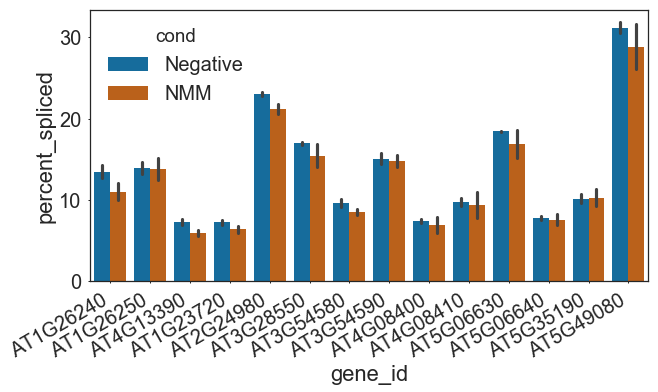

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))
intronless = percentage_spliced_long[percentage_spliced_long.gene_id.isin(exons[exons.n_exons == 1].gene_id)]
sns.barplot(x='gene_id',
            hue='cond',
            y='percent_spliced',
            data=intronless,
            ci='sd',
            order=ext_table.loc[(ext_table['AGI Identifier'].isin(intronless.gene_id)) & ext_table['class'].str.startswith('SP'), 'AGI Identifier'])
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.show()